# Homework 4 (Ibotta Products)

In [12]:
# import analysis packages
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, SimpleRNN, TextVectorization
from keras.models import Sequential
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf

### Data Preprocessing

In [2]:
# read data from .csv files
trainDF = pd.read_csv('./ibotta_train.csv')
testDF = pd.read_csv('./ibotta_test.csv')

# combine data sets for preprocessing
trainDF['origin'] = 'train'
testDF['origin'] = 'test'
fullDF = pd.concat([trainDF, testDF])

In [3]:
# text cleaning
fullDF['Brand_name'].where(-fullDF['Brand_name'].isna(), '', inplace = True)
fullDF['Brand_name'] = fullDF['Brand_name'].apply(lambda x: x.lower().replace("'", "").replace(",", "").replace(":", "").replace("-", "").replace(".", ""))
fullDF['Name'] = fullDF['Name'].apply(lambda x: x.lower().replace("'", "").replace(",", "").replace(":", "").replace("-", "").replace(".", ""))

# combine brand and name fields
fullDF['brandAlready'] = fullDF.apply(lambda x: x['Name'].find(x['Brand_name']), axis = 1)
fullDF.loc[fullDF.brandAlready == -1, 'Name'] = fullDF.loc[fullDF.brandAlready == -1, 'Brand_name'] + \
    ' ' + fullDF.loc[fullDF.brandAlready == -1, 'Name']
fullDF.drop('brandAlready', axis = 1, inplace = True)

In [4]:
# split data
trainDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'train'].drop('origin', axis = 1))
testDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'test'].drop(['origin', 'Category'], axis = 1))

# check dimensions of data
display(trainDF.shape)
display(testDF.shape)

# check data types
display(trainDF.info())

# peek at data
display(trainDF.head())

(8000, 5)

(1999, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          8000 non-null   int64  
 1   Name        8000 non-null   object 
 2   Brand_name  8000 non-null   object 
 3   Category    8000 non-null   object 
 4   Cat_code    8000 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 375.0+ KB


None

,Id,Name,Brand_name,Category,Cat_code
0,1,4c homestyle parmesan grated cheese 6 oz,4c,Dairy,2.0
1,2,4c 100% natural parmesan cheese 6 oz,,Dairy,2.0
2,3,4c parmesan & romano cheese grated,4c,Dairy,2.0
3,4,advance fast fixin country fried steaks with g...,fast fixin,Frozen Foods,3.0
4,5,borden dairy company borden salted 4 ct butter,borden dairy company,Dairy,2.0


### Text Vectorization

In [7]:
# find total number of unique words
unique_words = np.unique(np.array(' '.join(np.array(fullDF['Name'])).split(' ')))
max_length = len(unique_words)

# initialize empty dataframe
wordBag = pd.DataFrame(np.zeros((len(fullDF), max_length)), 
                       columns = unique_words)

# loop through product names
for i, productName in enumerate(fullDF['Name'].apply(lambda x: x.split(' '))):
    # loop through words in name
    for word in productName:
        # identify word presence
        wordBag.loc[i, word] = 1

# peek at bag of words
display(wordBag.head())

# split word bag
trainDFwordBag = wordBag.loc[0:7999]
testDFwordBag = wordBag.loc[8000:9999]

# check dimensions of data
display(trainDFwordBag.shape)
display(testDFwordBag.shape)

,,%,&,(101731),(12,(175,(18,(187,(4,(4th,...,zings,zip,zippak¨∆,zipçƒîpak,ziti,zoi,zucchini,|,çƒî,çƒï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(8000, 4977)

(1999, 4977)

In [10]:
# tag data with iterable object
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(fullDF['Name'].apply(lambda x: x.split(' ')))]

# doc2vec vectorization function
def doc2vecGen(size):
    # train doc2vec tokenizer
    tokenizer = Doc2Vec(tagged_data, vector_size = size, min_count = 1, epochs = 100)
    tokenizer.build_vocab(list(tagged_data))
    tokenizer.train(list(tagged_data), 
                    total_examples = tokenizer.corpus_count, 
                    epochs = tokenizer.epochs)
    
    # vectorize text data
    doc2vecDF = fullDF['Name'].apply(lambda x: tokenizer.infer_vector(x.split(' ')))
    doc2vecDF = pd.DataFrame(np.array(doc2vecDF))[0].apply(pd.Series)

    # split vectorized data
    trainDFdoc2vec = doc2vecDF.loc[0:7999]
    testDFdoc2vec = doc2vecDF.loc[8000:9999]

    return(trainDFdoc2vec, testDFdoc2vec)

In [17]:
# keras tokenizer function
def textVecGen(size):
    # train keras tokenizer
    tokenizer = TextVectorization(output_sequence_length = size)
    tokenizer.adapt(fullDF['Name'])

    # vectorize data
    textVecDF = pd.DataFrame(tokenizer(fullDF['Name']))
    
    # split vectorized data
    trainDFtextVec = textVecDF.loc[0:7999]
    testDFtextVec = textVecDF.loc[8000:9999]

    return(trainDFtextVec, testDFtextVec)

In [22]:
# model evaluation function
def EvaluateModel(model, X_train):
    # set random seeds
    np.random.seed(542023)
    tf.random.set_seed(542023)

    # print model summary
    try:
        model.summary()
    except:
        pass

    # compile model
    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    # define early stopping criterion
    early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3)

    # train deep learning model
    trained = model.fit(X_train,
                        to_categorical(trainDF['Cat_code']),
                        epochs = 100,
                        batch_size = 64,
                        callbacks = early,
                        validation_split = 0.2,
                        verbose = 2)
    
    # prepare model evaluation
    acc = trained.history['accuracy']
    val_acc = trained.history['val_accuracy']
    loss = trained.history['loss']
    val_loss = trained.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # final validation accuracy
    display(f"Validation accuracy: {round(val_acc[-1] * 100, 2)}%")

    # plot training accuracy
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))
    ax1.plot(epochs, acc, 'bo', label = 'Training acc')
    ax1.plot(epochs, val_acc, 'b', label = 'Validation acc')
    ax1.set(xlabel = 'Epochs', ylabel = 'Accuracy')
    ax1.legend()
    ax2.plot(epochs, loss, 'bo', label = 'Training loss')
    ax2.plot(epochs, val_loss, 'b', label = 'Validation loss')
    ax2.set(xlabel = 'Epochs', ylabel = 'Loss')
    ax2.legend()
    fig.suptitle('Evaluation Metrics')

Epoch 1/100
100/100 - 2s - loss: 0.5930 - accuracy: 0.8037 - val_loss: 0.3164 - val_accuracy: 0.9000 - 2s/epoch - 22ms/step
Epoch 2/100
100/100 - 2s - loss: 0.1017 - accuracy: 0.9706 - val_loss: 0.3032 - val_accuracy: 0.9081 - 2s/epoch - 17ms/step
Epoch 3/100
100/100 - 2s - loss: 0.0455 - accuracy: 0.9858 - val_loss: 0.3136 - val_accuracy: 0.9281 - 2s/epoch - 17ms/step
Epoch 4/100
100/100 - 2s - loss: 0.0289 - accuracy: 0.9920 - val_loss: 0.3541 - val_accuracy: 0.9244 - 2s/epoch - 17ms/step
Epoch 5/100
100/100 - 2s - loss: 0.0188 - accuracy: 0.9939 - val_loss: 0.3704 - val_accuracy: 0.9262 - 2s/epoch - 18ms/step


'Validation accuracy: 92.62%'

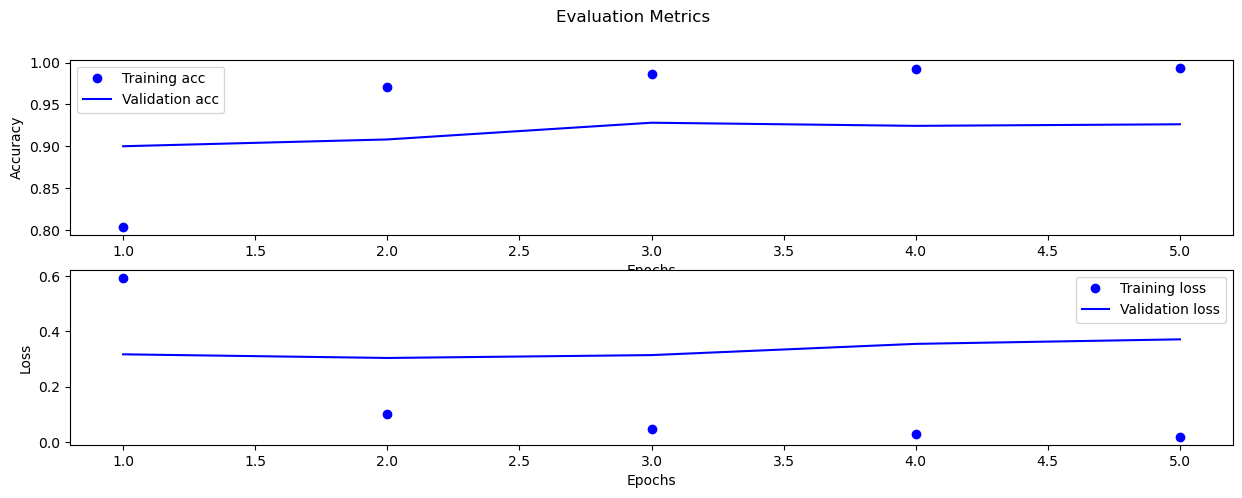

In [24]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFwordBag)